## Classifying mangrove damage and recover due to tropical cyclones
- based on Emmas_code_TC_mangroves.py
- need to use geotiffs in google drive for the windfield data input

### NCI data
/g/data/u46/users/ea6141/more_mangroves  

cyclone_damage_tally_notsure folder means it's not sure if mangrove is there on not (i.e. only 3 or 4 obs for the year)

/g/data/r78/mangroves


In [1]:
# need to change so it reprojects in the nb not externally
# https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Reprojecting_data.html

# commandline used at the moment for reprojecting
# gdalwarp -t_srs EPSG:3577 -tr 30.0 30.0 -r near -of GTiff Yasi.tif Yasi_30m_EPSG3577.tif

In [2]:
import datacube
from datacube.model import Measurement
import numpy as np
import xarray as xr
from os import path
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.utils.geometry import CRS
import pandas as pd
import os
from  datacube import Datacube
from datacube.utils import geometry
import pickle
import sys
import rioxarray
dc = datacube.Datacube(app="cyclone mangroves")

from datacube.testutils.io import rio_slurp_xarray

from Cyclone_damage_funcs import *

### fill in data (doing one cyclone at a time for the moment)

In [3]:
cyclone_name = 'Larry'
cyclone_time = 2006

### load in geotiff

In [4]:
geotiff_path = './FINALlocalWind/'+cyclone_name+'_25m_EPSG3577.tif'
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)
# change -9999 to 0
geotiff_da = xr.where(geotiff_da == -9999, 0, geotiff_da.values)
# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')
# Rename the variable to a more useful name
dataset = geotiff_ds.rename({1: 'wind_speed'})

### rework to get geotiff as identical dc.load for mangroves

In [5]:
# get extent of cyclone dataset
geobox = dataset.extent
# get the cyclone start time
start_time = cyclone_time

# get time of cyclone
time_of_cyclone = (str(start_time) + '-01-01', str(start_time) + '-12-31')

# find datasets for mangrove canopy cover at cyclone time
time_of_cyclone_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_of_cyclone, geopolygon=geobox)

# at time of cyclone mangrove canopy cover datasets, group by time
time_of_cyclone_datasets = dc.group_datasets(time_of_cyclone_datasets, group_by='time')

# get geometry box from geotiff
full_box = geometry.GeoBox.from_geopolygon(geobox, resolution=(25, -25))

# measurements for mangrove canopy cover
measurement = [Measurement(name='canopy_cover_class', dtype='int16', nodata=-1, units='1')]

# load mangrove canopy cover at time of cyclone
time_of_cyclone_data = dc.load_data(time_of_cyclone_datasets, geobox = full_box, measurements=measurement)

# load in geotiff again but with identical extent from dc.load mangroves
cyclone_da = rio_slurp_xarray(geotiff_path, gbox=time_of_cyclone_data.geobox)
# add time dimension
cyclone_da_time = cyclone_da.expand_dims(dim={"time": time_of_cyclone_data.time})
# Covert our xarray.DataArray into a xarray.Dataset
cyclone_ds = cyclone_da_time.to_dataset(name="wind_speed")

# copy over attributes
cyclone_ds.attrs['grid_mapping'] = time_of_cyclone_data.attrs['grid_mapping']
cyclone_ds.attrs['crs'] = time_of_cyclone_data.attrs['crs']


### load mangrove data before and after cyclone (on extent of geotiff)

In [7]:
# get time query before cyclone
time_before_cyclone = (str(start_time - 1) + '-01-01', str(start_time - 1) + '-12-31')
# get time query after cyclone
time_after_cyclone = (str(start_time) + '-01-01', '2021-12-31')

# find all datasets for mangrove canopy cover before cyclone
bc_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_before_cyclone, geopolygon=geobox)

In [8]:
# loop through extents for the different categories
cyclone_extent = {}
k = 0
for d in bc_datasets:
    cyclone_extent[k] = d.extent
    k += 1

In [9]:
# before cyclone mangrove canopy cover datasets, group by time
bc_datasets = dc.group_datasets(bc_datasets, group_by='time')
# find all datasets for mangrove canopy cover after cyclone
ac_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_after_cyclone, geopolygon=geobox)
# after cyclone mangrove canopy cover datasets, group by time
ac_datasets = dc.group_datasets(ac_datasets, group_by='time')

In [10]:
# set up empty variables
wind_cat_full = None
all_wind_cat_full = None

for key, value in cyclone_extent.items():
    # get polygon extent of cyclone
    loading_polygon = value.intersection(geobox.to_crs(value.crs))
    # get bounding box of polygon with 25m res
    loading_box = geometry.GeoBox.from_geopolygon(loading_polygon, resolution=(25, -25))
    # run the function damage_level_by_geo
    wind_cat, all_wind_cat = damage_level_by_geo('./', cyclone_name, 
                                             cyclone_ds, bc_datasets, ac_datasets, 
                                             loading_box, dump=False)

    if wind_cat_full is None:
        wind_cat_full = wind_cat
        all_wind_cat_full = all_wind_cat
    else:
        wind_cat_full += wind_cat
        all_wind_cat_full += all_wind_cat
    print(wind_cat_full)
    print(all_wind_cat_full)

           0         1         2       3        4
C1  7.456875  0.408125  0.000625  0.0075  0.00375
C2       0.0       0.0       0.0     0.0      0.0
C3       0.0       0.0       0.0     0.0      0.0
C4       0.0       0.0       0.0     0.0      0.0
C5       0.0       0.0       0.0     0.0      0.0
           1    2         3    4    5
C1  2.181875  0.0  0.118125  0.0  0.0
C2       0.0  0.0       0.0  0.0  0.0
C3       0.0  0.0       0.0  0.0  0.0
C4       0.0  0.0       0.0  0.0  0.0
C5       0.0  0.0       0.0  0.0  0.0
           0         1         2       3        4
C1  7.456875  0.408125  0.000625  0.0075  0.00375
C2       0.0       0.0       0.0     0.0      0.0
C3       0.0       0.0       0.0     0.0      0.0
C4       0.0       0.0       0.0     0.0      0.0
C5       0.0       0.0       0.0     0.0      0.0
           1    2         3    4    5
C1  2.181875  0.0  0.118125  0.0  0.0
C2       0.0  0.0       0.0  0.0  0.0
C3       0.0  0.0       0.0  0.0  0.0
C4       0.0  0.0   

In [11]:
with open('./Pickle_damage_results/'+cyclone_name+'_tally.pkl', 'wb') as f:
    pickle.dump((wind_cat_full, all_wind_cat_full), f)

In [12]:
with open('./Pickle_damage_results/'+cyclone_name+'_tally.pkl', 'rb') as f:
    wind_cat_full, all_wind_cat_full = pickle.load(f)

In [13]:
# C1 - C5: category of cyclone windspeeed
# 0 = no change (km2)
# 1 = minor reduction
# 2 = major reduction
# 3 = loss of woodland
# 4 = loss of forest
wind_cat_full

,0,1,2,3,4
C1,252.96375,18.823125,0.728125,0.394375,0.624375
C2,34.598125,3.738125,0.00875,0.0525,0.138125
C3,17.17625,12.863125,0.53125,0.101875,0.13
C4,0.00125,0.00125,0.0,0.0,0.0
C5,0.0,0.0,0.0,0.0,0.0


In [14]:
# C1 - C5: category of cyclone windspeeed
# 0 = no change (km2)
# 1 = temporary reduction
# 2 = persistent reduction
# 3 = temporary loss
# 4 = persistent loss
# 5 = total loss
all_wind_cat_full

,1,2,3,4,5
C1,196.623125,0.023125,15.018125,0.033125,0.043125
C2,31.4175,0.034375,2.339375,0.004375,0.0025
C3,18.36625,0.00375,3.553125,0.008125,0.0025
C4,0.001875,0.0,0.0,0.0,0.0
C5,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Wind speed categories')

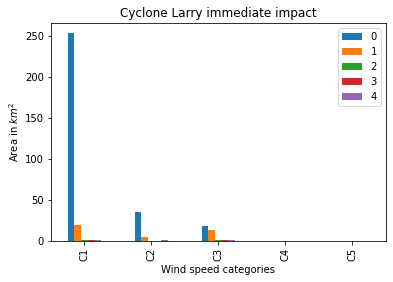

In [15]:
figure_a = wind_cat_full.astype('float').plot(kind='bar', title='Cyclone '+ cyclone_name +' immediate impact')
figure_a.set_ylabel('Area in $km^2$')
figure_a.set_xlabel('Wind speed categories')

Text(0.5, 0, 'Wind speed categories')

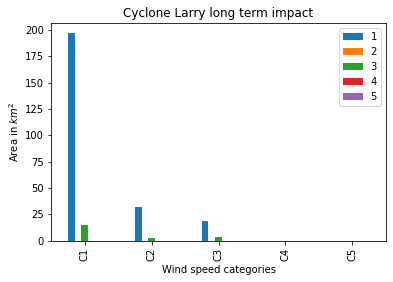

In [16]:
figure_a = all_wind_cat_full.astype('float').plot(kind='bar', title='Cyclone '+ cyclone_name +' long term impact')
figure_a.set_ylabel('Area in $km^2$')
figure_a.set_xlabel('Wind speed categories')